In [1]:
import os
import sys
import glob
import time
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

%matplotlib inline

In [2]:
from unet import UNet
from fcn import *
from utils import *
from dataset import *

In [3]:
MODEL_PATH = 'models/UCSDped1/'
DATA_DIR = 'data/UCSD_processed/UCSDped1/'
TRAIN_PATTERN = os.path.join(DATA_DIR, 'Train/*/*.png')
train_paths = sorted(glob.glob(TRAIN_PATTERN))

## Training

In [8]:
# hyperparams
gamma = 0.6
depth = 5
batch_size = 8
num_epochs = 30
print_intv = 1

In [9]:
MODEL_PATH = './models/UCSDped1/gamma{:.1f}_depth{}/'.format(gamma, depth)
os.makedirs(MODEL_PATH, exist_ok=True)

In [10]:
g_lr = 1e-4
d_lr = 4e-4
momentum = 0.9
size = 224
fcn_model = FCN_224_11_mini
# fcn_model = FCN_224_11

In [11]:
train_dataset = Dataset(train_paths, (size, size), rgb=True)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

G = UNet(3, 3, depth=depth).to(device)
D = fcn_model(3).to(device)
G_optimizer = optim.Adam(G.parameters(), lr=g_lr)
D_optimizer = optim.Adam(D.parameters(), lr=d_lr)
# G_optimizer = optim.SGD(G.parameters(), lr=g_lr, momentum=momentum)
# D_optimizer = optim.SGD(D.parameters(), lr=d_lr, momentum=momentum)
criterion = l2_BCE

Epoch 0: 11.5min, D_loss: 0.377739, G_loss: 0.225183


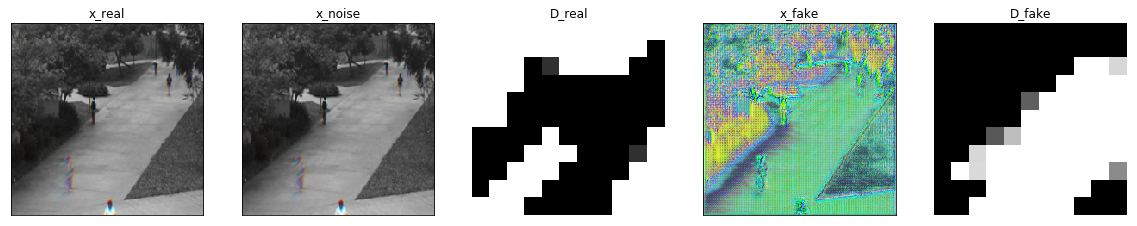

Epoch 1: 11.5min, D_loss: 0.541833, G_loss: 0.295521


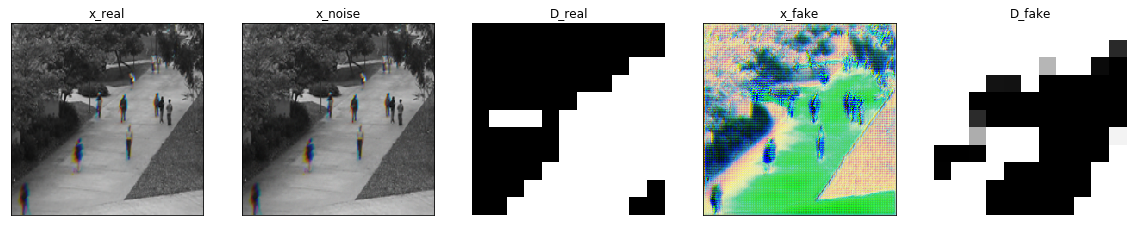

Epoch 2: 11.5min, D_loss: 0.287091, G_loss: 0.160129


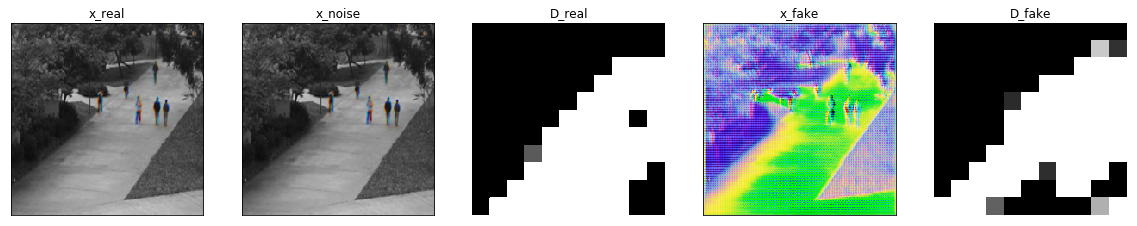

Epoch 3: 11.5min, D_loss: 0.297110, G_loss: 0.205291


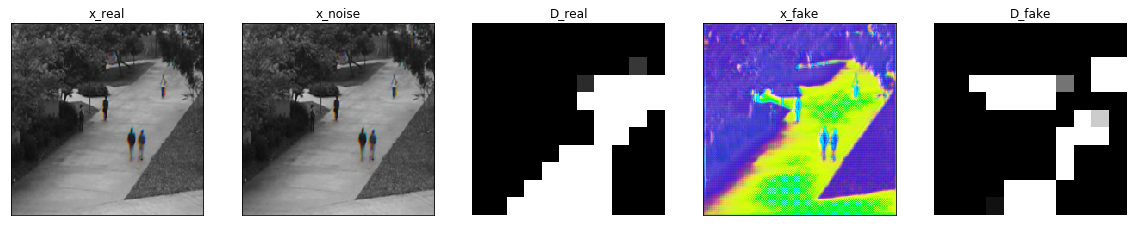

Epoch 4: 11.5min, D_loss: 0.204114, G_loss: 0.118155


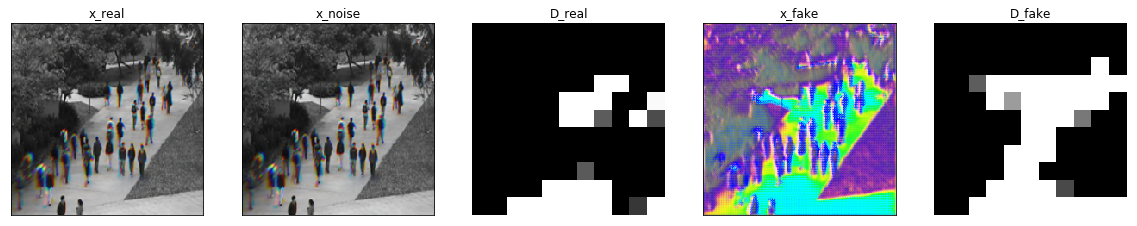

Epoch 5: 11.6min, D_loss: 0.341205, G_loss: 0.185633


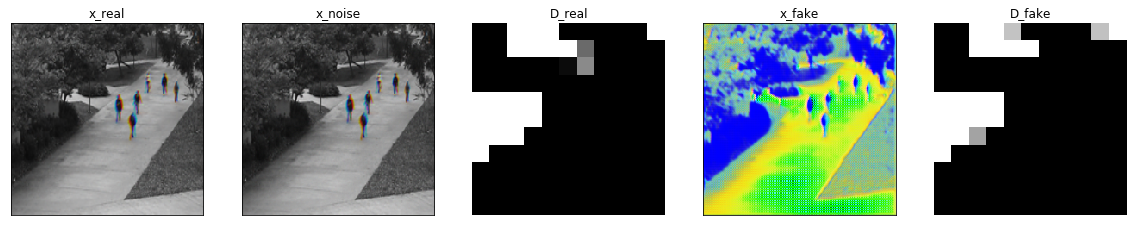

Epoch 6: 11.5min, D_loss: 0.183289, G_loss: 0.069711


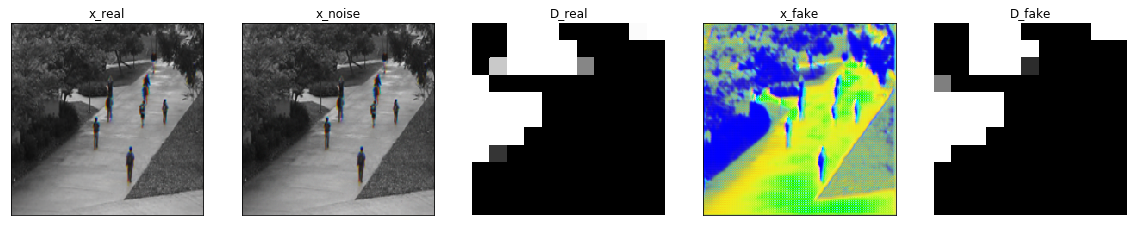

Epoch 7: 11.5min, D_loss: 0.202033, G_loss: 0.108806


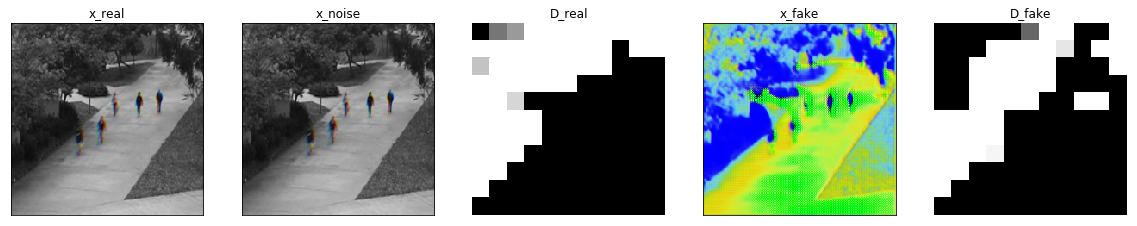

KeyboardInterrupt: 

In [12]:
# Training
history = {'D_loss': [], 'G_loss': []}

D.train()
G.train()
D_best_loss = np.inf
G_best_loss = np.inf

for epoch in range(num_epochs):
    D_running_loss = 0
    G_running_loss = 0
    _D_real_loss = 0
    _D_fake_loss = 0
    
    start = time.time()
    for x_real in train_loader:
        D.zero_grad()
        G.zero_grad()
        D_optimizer.zero_grad()
        G_optimizer.zero_grad()
        
        x_real = x_real.to(device) 

        ### Update Discriminator ###
        # real
        D_real = D(x_real)
        y_real = torch.ones(D_real.size()).to(device)
        y_fake = torch.zeros(D_real.size()).to(device)
        D_real_loss = criterion(D_real, y_real)
        
        # fake
        eta = torch.randn(x_real.size()).to(device)
        x_noise = x_real + gamma * eta / 127.5
        x_fake = G(x_noise)
        D_fake = D(x_fake.detach())  # detach for computational speed
        D_fake_loss = criterion(D_fake, y_fake)
        
        # update params
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.item()
        # for debug
        _D_real_loss += D_real_loss.item()
        _D_fake_loss += D_fake_loss.item()
        
        ### Update Generator ###
        eta = torch.randn(x_real.size()).to(device)
        x_noise = x_real + gamma * eta / 127.5
        x_fake = G(x_noise)
        D_fake = D(x_fake)
        
        # update params
        G_loss = criterion(D_fake, y_real)
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.item()
    
    elapsed_time = (time.time() - start) / 60
    
    D_running_loss /= len(train_loader)
    G_running_loss /= len(train_loader)
    history['D_loss'].append(D_running_loss)
    history['G_loss'].append(G_running_loss)
    
    torch.save(D.state_dict(), MODEL_PATH+'D_{:03d}.pth'.format(epoch))
    torch.save(G.state_dict(), MODEL_PATH+'G_{:03d}.pth'.format(epoch))
    
    if D_running_loss < D_best_loss:
        D_best_loss = D_running_loss
        torch.save(D.state_dict(), MODEL_PATH+'D.pth'.format(epoch))
    if G_running_loss < G_best_loss:
        G_best_loss = G_running_loss
        torch.save(G.state_dict(), MODEL_PATH+'G.pth')
    
    print('Epoch {}: {:.1f}min, D_loss: {:.6f}, G_loss: {:.6f}'.format(epoch, elapsed_time, D_running_loss, G_running_loss))
    
    if epoch % print_intv == 0:
        imgs = {
            'x_real': tanh2sigmoid(x_real),
            'x_noise': tanh2sigmoid(x_noise),
            'D_real': D_real,
            'x_fake': tanh2sigmoid(x_fake),
            'D_fake': D_fake,
        }
        idxs = np.random.randint(0, x_real.size(0), [1])
        show_imgs(imgs, idxs)

# (112,112)

In [39]:
# hyperparams
gamma = 0.6
depth = 4
batch_size = 8
num_epochs = 20
print_intv = 1

In [40]:
MODEL_PATH = './models/UCSDped1/gamma{:.1f}_depth{}/'.format(gamma, depth)
os.makedirs(MODEL_PATH, exist_ok=True)

In [44]:
g_lr = 2e-4
d_lr = 1e-5
size = 112
fcn_model = FCN_112_11

In [45]:
train_dataset = Dataset(train_paths, (size, size), rgb=True)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

G = UNet(3, 3, depth=depth).to(device)
D = fcn_model(3).to(device)
G_optimizer = optim.Adam(G.parameters(), lr=g_lr)
D_optimizer = optim.Adam(D.parameters(), lr=d_lr)
criterion = l2_BCE

Epoch 0: 3.8min, D_loss: 2.709765, G_loss: 1.428169


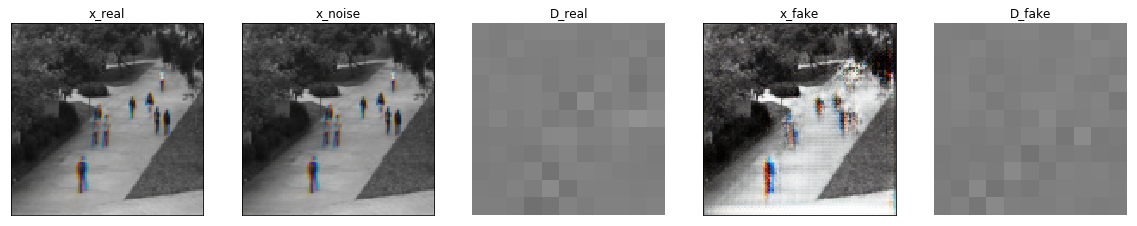

Epoch 1: 3.8min, D_loss: 2.777887, G_loss: 1.390921


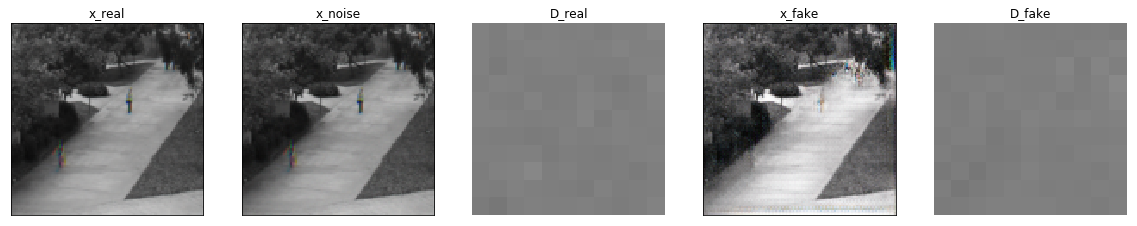

Epoch 2: 3.8min, D_loss: 2.777992, G_loss: 1.387214


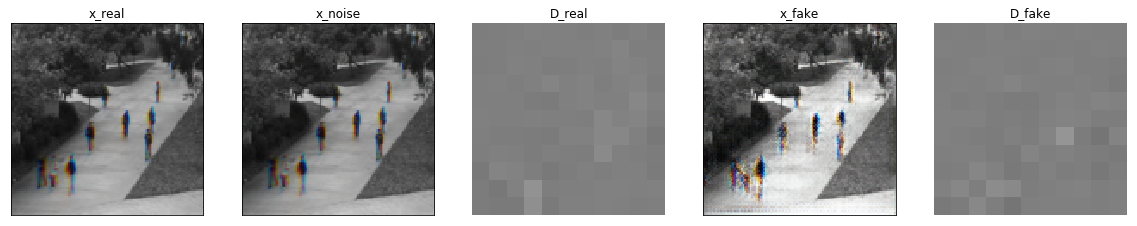

Epoch 3: 3.9min, D_loss: 2.776652, G_loss: 1.386020


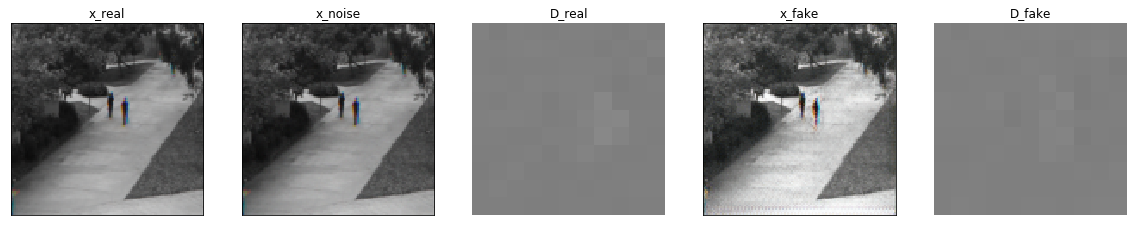

Epoch 4: 3.8min, D_loss: 2.775367, G_loss: 1.386119


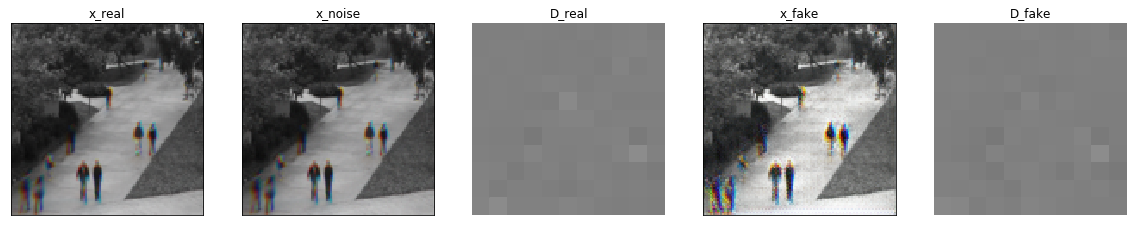

Epoch 5: 3.8min, D_loss: 2.774744, G_loss: 1.386289


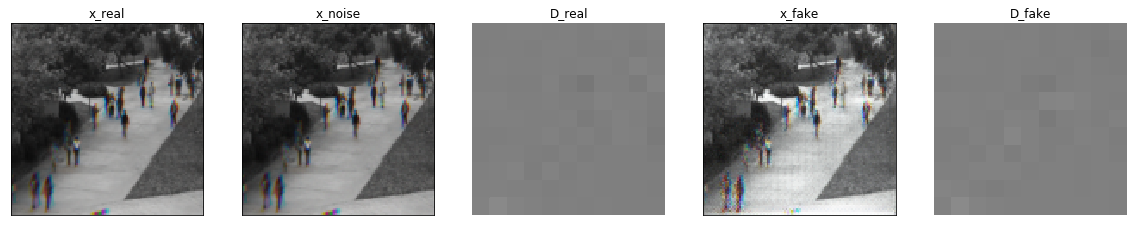

Epoch 6: 3.8min, D_loss: 2.774149, G_loss: 1.386359


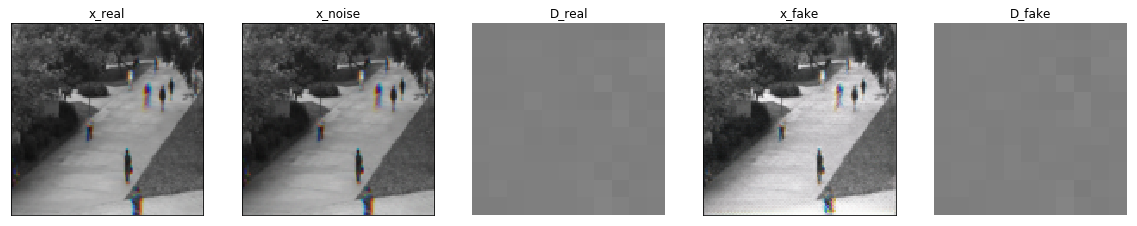

Epoch 7: 3.8min, D_loss: 2.773936, G_loss: 1.386273


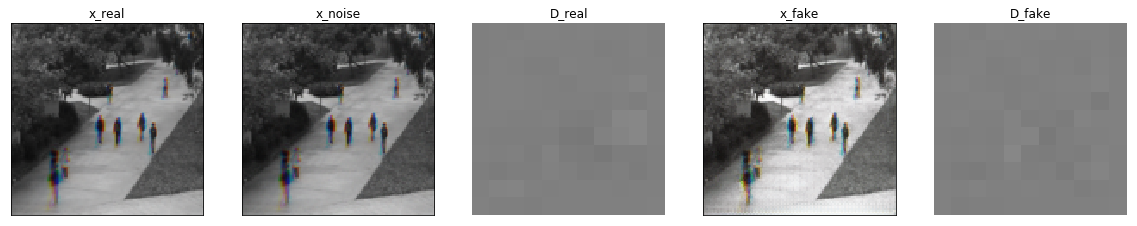

Epoch 8: 3.8min, D_loss: 2.773726, G_loss: 1.386517


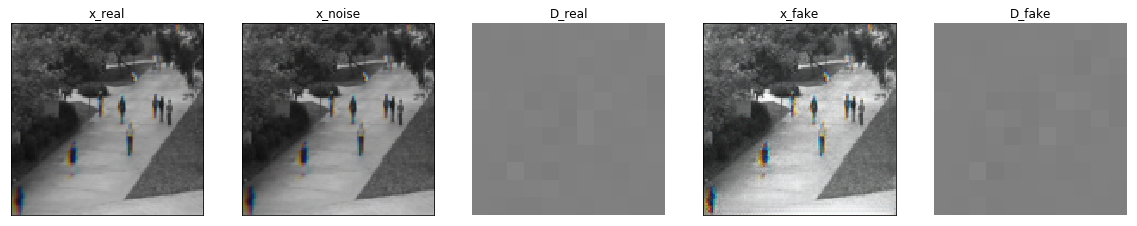

Epoch 9: 3.8min, D_loss: 2.773573, G_loss: 1.386578


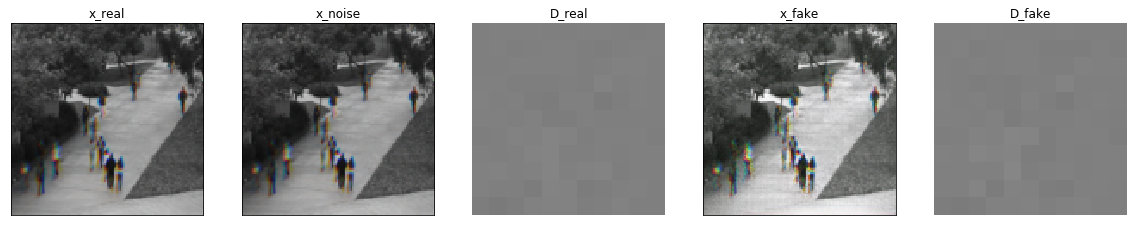

Epoch 10: 3.8min, D_loss: 2.773582, G_loss: 1.386329


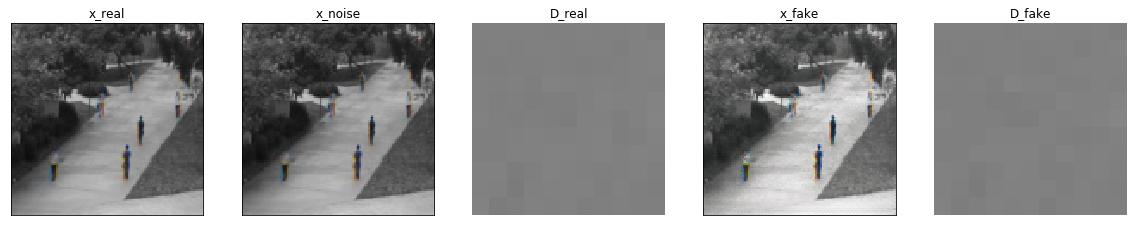

Epoch 11: 3.8min, D_loss: 2.773382, G_loss: 1.386448


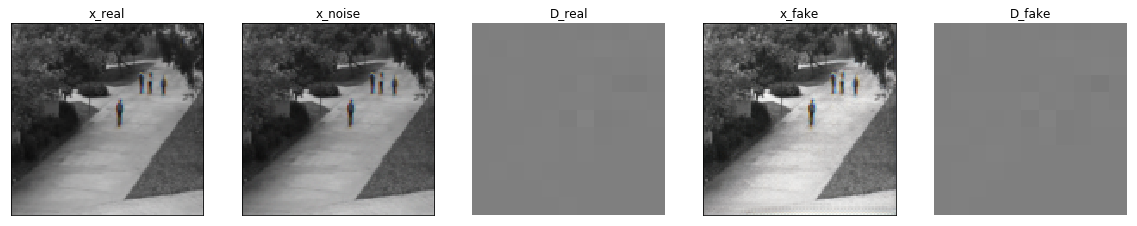

KeyboardInterrupt: 

In [46]:
# Training
history = {'D_loss': [], 'G_loss': []}

D.train()
G.train()
D_best_loss = np.inf
G_best_loss = np.inf

for epoch in range(num_epochs):
    D_running_loss = 0
    G_running_loss = 0
    _D_real_loss = 0
    _D_fake_loss = 0
    
    start = time.time()
    for x_real in train_loader:
        D.zero_grad()
        G.zero_grad()
        D_optimizer.zero_grad()
        G_optimizer.zero_grad()
        
        x_real = x_real.to(device) 

        ### Update Discriminator ###
        # real
        D_real = D(x_real)
        y_real = torch.ones(D_real.size()).to(device)
        y_fake = torch.zeros(D_real.size()).to(device)
        D_real_loss = criterion(D_real, y_real)
        
        # fake
        eta = torch.randn(x_real.size()).to(device)
        x_noise = x_real + gamma * eta / 127.5
        x_fake = G(x_noise)
        D_fake = D(x_fake.detach())  # detach for computational speed
        D_fake_loss = criterion(D_fake, y_fake)
        
        # update params
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.item()
        
        ### Update Generator ###
        eta = torch.randn(x_real.size()).to(device)
        x_noise = x_real + gamma * eta / 127.5
        x_fake = G(x_noise)
        D_fake = D(x_fake)
        
        # update params
        G_loss = criterion(D_fake, y_real)
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.item()
    
    elapsed_time = (time.time() - start) / 60
    
    D_running_loss /= len(train_loader)
    G_running_loss /= len(train_loader)
    history['D_loss'].append(D_running_loss)
    history['G_loss'].append(G_running_loss)
    
    torch.save(D.state_dict(), MODEL_PATH+'D_{:03d}.pth'.format(epoch))
    torch.save(G.state_dict(), MODEL_PATH+'G_{:03d}.pth'.format(epoch))
    
    if D_running_loss < D_best_loss:
        D_best_loss = D_running_loss
        torch.save(D.state_dict(), MODEL_PATH+'D.pth'.format(epoch))
    if G_running_loss < G_best_loss:
        G_best_loss = G_running_loss
        torch.save(G.state_dict(), MODEL_PATH+'G.pth')
    
    print('Epoch {}: {:.1f}min, D_loss: {:.6f}, G_loss: {:.6f}'.format(epoch, elapsed_time, D_running_loss, G_running_loss))
    
    if epoch % print_intv == 0:
        imgs = {
            'x_real': tanh2sigmoid(x_real),
            'x_noise': tanh2sigmoid(x_noise),
            'D_real': D_real,
            'x_fake': tanh2sigmoid(x_fake),
            'D_fake': D_fake,
        }
        idxs = np.random.randint(0, x_real.size(0), [1])
        show_imgs(imgs, idxs)

# 推論

In [156]:
real_path = DATA_DIR + '/Test/Test014/010.png'
gt_path =  'data/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test014_gt/010.bmp'
real_img = Image.open(real_path).convert('RGB')
gt_img = Image.open(gt_path)
x_real = train_dataset.transform(real_img).unsqueeze(0).to(device)

G.load_state_dict(torch.load(MODEL_PATH + 'G_011.pth'))
D.load_state_dict(torch.load(MODEL_PATH + 'D_011.pth'))
x_real = x_real.to(device)
x_fake = G(x_real)
D_fake = D(x_fake)
diff = torch.abs(x_real-x_fake)
heat = diff.data.cpu().numpy()[0,0]    

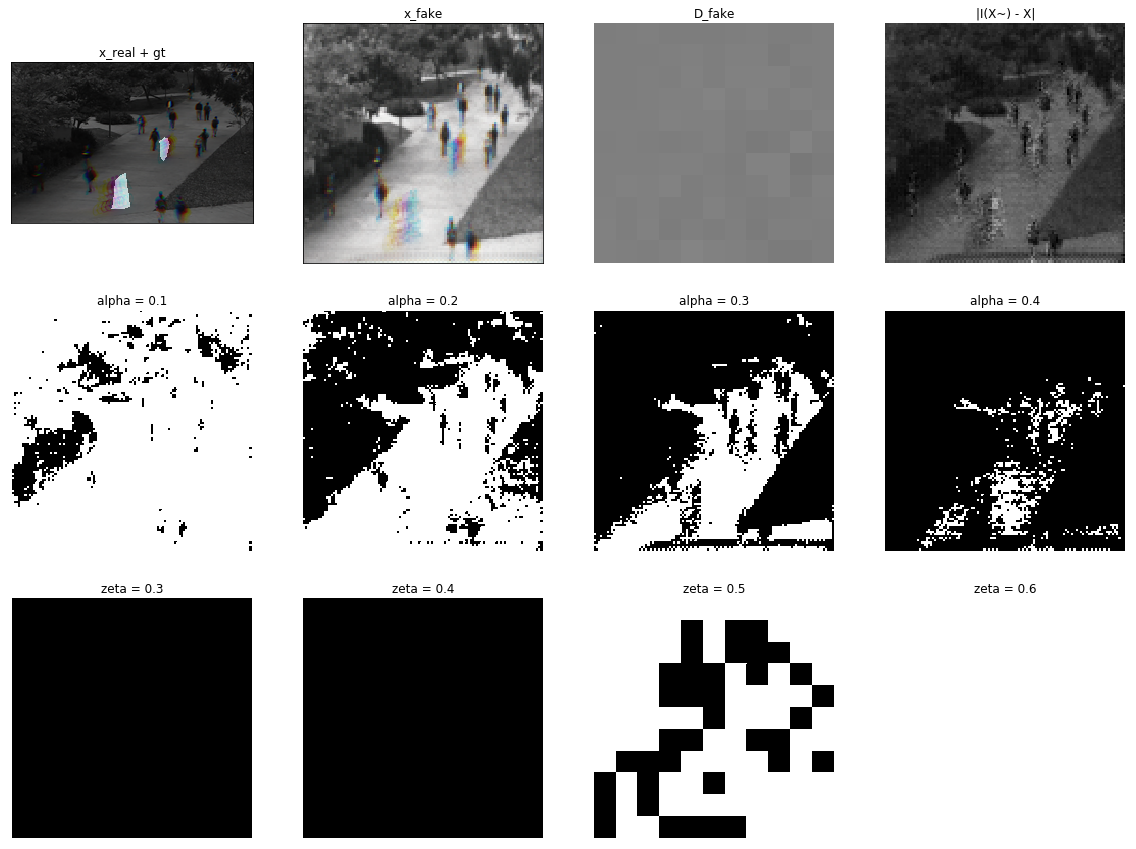

In [157]:
visualize(real_img, gt_img, x_real, x_fake, D_fake, heat)

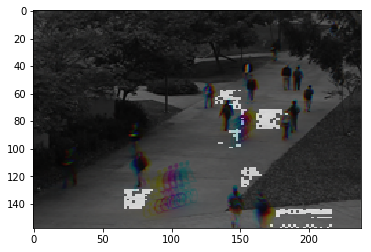

In [158]:
visualize_mask(real_img, heat, D_fake, alpha=0.38, zeta=0.49)

In [159]:
real_path = DATA_DIR + '/Test/Test019/100.png'
gt_path =  'data/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test019_gt/100.bmp'
real_img = Image.open(real_path).convert('RGB')
gt_img = Image.open(gt_path)
x_real = train_dataset.transform(real_img).unsqueeze(0).to(device)

G.load_state_dict(torch.load(MODEL_PATH + 'G_011.pth'))
D.load_state_dict(torch.load(MODEL_PATH + 'D_011.pth'))
x_real = x_real.to(device)
x_fake = G(x_real)
D_fake = D(x_fake)
diff = torch.abs(x_real-x_fake)
heat = diff.data.cpu().numpy()[0,0]    

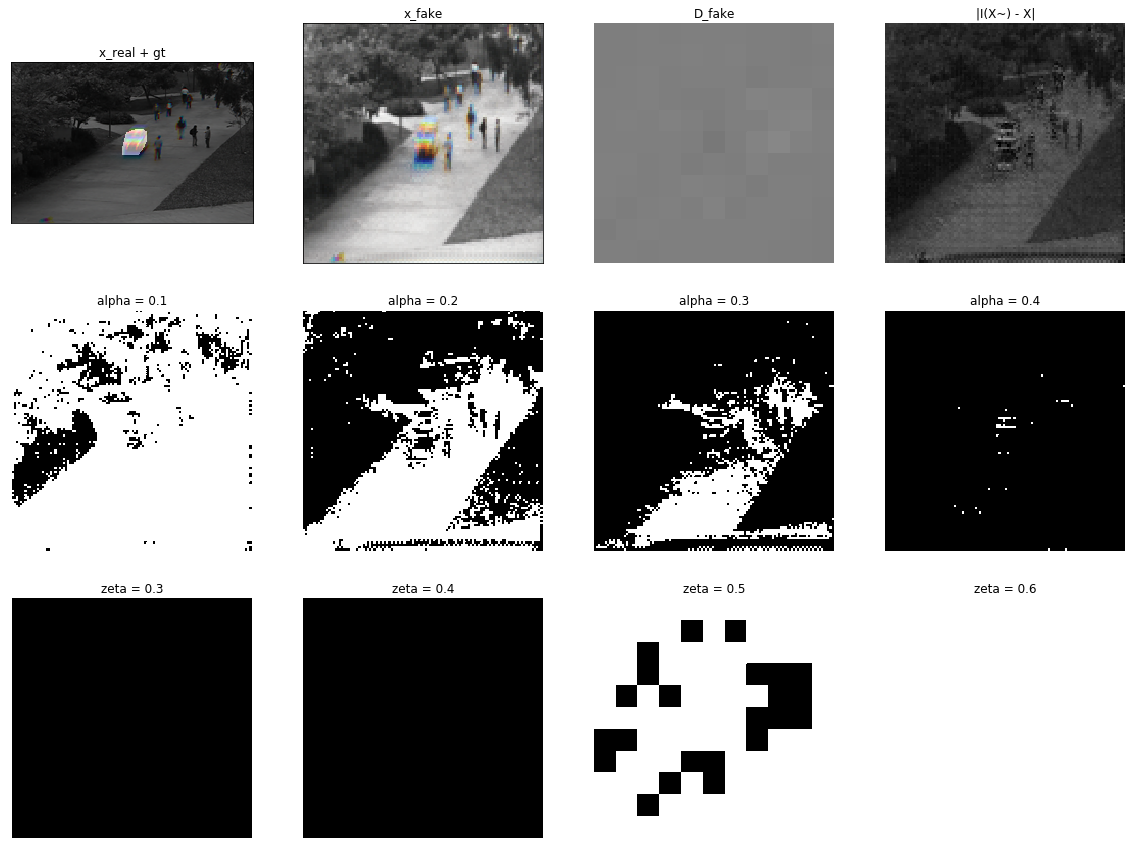

In [160]:
visualize(real_img, gt_img, x_real, x_fake, D_fake, heat)

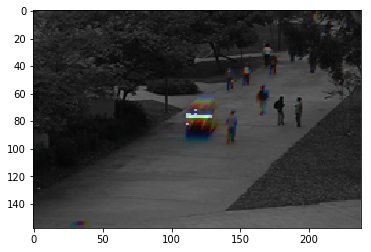

In [164]:
visualize_mask(real_img, heat, D_fake, alpha=0.4, zeta=0.48)